In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np
import pandas as pd
from kaggle.competitions import twosigmanews

env_parallel = twosigmanews.make_env()
(marketdf, newsdf) = env_parallel.get_training_data()

from sklearn.model_selection import train_test_split
import lightgbm as lgb


def prepare_data(marketdf, newsdf):
    # a bit of feature engineering
    marketdf['time'] = marketdf.time.dt.strftime("%Y%m%d").astype(int)
    marketdf['bartrend'] = marketdf['close'] / marketdf['open']
    marketdf['average'] = (marketdf['close'] + marketdf['open'])/2
    marketdf['pricevolume'] = marketdf['volume'] * marketdf['close']
    
    newsdf['time'] = newsdf.time.dt.strftime("%Y%m%d").astype(int)
    newsdf['assetCode'] = newsdf['assetCodes'].map(lambda x: list(eval(x))[0])
    newsdf['position'] = newsdf['firstMentionSentence'] / newsdf['sentenceCount']
    newsdf['coverage'] = newsdf['sentimentWordCount'] / newsdf['wordCount']

    # filter pre-2012 data, no particular reason
    marketdf = marketdf.loc[marketdf['time'] > 20120000]
    
    # get rid of extra junk from news data
    droplist = ['sourceTimestamp','firstCreated','sourceId','headline','takeSequence','provider','firstMentionSentence',
                'sentenceCount','bodySize','headlineTag','marketCommentary','subjects','audiences','sentimentClass',
                'assetName', 'assetCodes','urgency','wordCount','sentimentWordCount']
    newsdf.drop(droplist, axis=1, inplace=True)
    marketdf.drop(['assetName', 'volume'], axis=1, inplace=True)
    
    # combine multiple news reports for same assets on same day
    newsgp = newsdf.groupby(['time','assetCode'], sort=False).aggregate(np.mean).reset_index()
    
    # join news reports to market data, note many assets will have many days without news data
    return pd.merge(marketdf, newsgp, how='left', on=['time', 'assetCode'], copy=False) #, right_on=['time', 'assetCodes'])


def post_scaling(df):
    mean, std = np.mean(df), np.std(df)
    df = (df - mean)/ (std * 8)
    return np.clip(df,-1,1)



   

Loading the data... This could take a minute.
Done!


In [3]:
ttt=marketdf["returnsOpenNextMktres10"]

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
ttt.describe()


count    4.072956e+06
mean     1.405528e-02
std      7.242467e+00
min     -1.375045e+03
25%     -2.970509e-02
50%      1.044642e-03
75%      3.152750e-02
max      9.761338e+03
Name: returnsOpenNextMktres10, dtype: float64

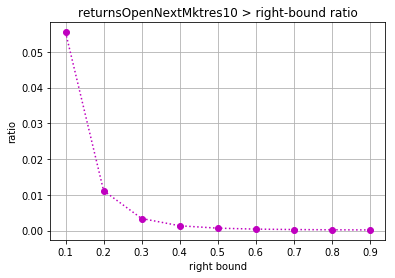

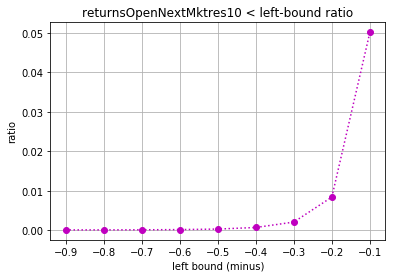

In [69]:
### right threshold 
pos_threshold = [i*(1e-1) for i in range(1,10)]
train_set_length = len(marketdf.index)
pos_percent = []
for val in pos_threshold:
    pos_percent.append(sum(ttt>val)/train_set_length)
plt.figure()
plt.plot(pos_threshold,pos_percent,'mo:')
plt.xlabel('right bound')
plt.ylabel('ratio')
plt.title('returnsOpenNextMktres10 > right-bound ratio')
plt.grid()
#### left threshold 
neg_threshold = [i*(1e-1) for i in range(1,10)]
neg_threshold = [-1*x for x in neg_threshold][::-1]
train_set_length = len(marketdf.index)
neg_percent = []
for val in neg_threshold:
    neg_percent.append(sum(ttt<val)/train_set_length)
plt.figure()
plt.plot(neg_threshold,neg_percent,'mo:')
plt.xlabel('left bound (minus)')
plt.ylabel('ratio')
plt.title('returnsOpenNextMktres10 < left-bound ratio')
plt.grid()